In [30]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt


def sampletoimage(sample):
 img =  Image.fromarray(np.zeros((255,255)).astype('uint8'))
 draw = ImageDraw.Draw(img)    
 for f,s,g in zip(font_size,sample,grid):
  font = ImageFont.truetype("./LiberationMono-Bold.ttf", size=f)
  draw.text(g,str(s),font=font, fill='white')

 return [np.array(img) for _ in range(3)]

In [31]:
def SSUM(df,columns):
    if(columns  != []):
        return (df[columns[0]]+SSUM(df,columns[1:]))
    return ''

categoricals=['sex','cp','fbs','restecg','exng','slp','caa','thall']
df=pd.read_csv('heart.csv')
X=df.drop(['output'],axis=1).applymap(str)
Y=df[['output']].to_numpy()

X['categoricals']=SSUM(X,categoricals)
X=X.drop(categoricals,axis=1).to_numpy()[:,::-1]



In [3]:
grid=[(0,0),(0,65),(0,130),(0,195),(140,100),(140,175)]
font_size=[50]*6

In [4]:
X=np.array(list(map(sampletoimage,X)))

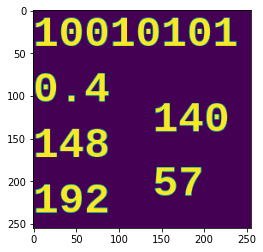

In [5]:
plt.imshow(X[5,0])

In [6]:
import torch.nn as nn
from torchvision import models

def resnet18update(net, only_last = True):
   if only_last:
      for name, param in net.named_parameters():
        if 'fc' not in name and 'act' not in name: param.requires_grad = False  # freezing all except classifier
      for name, param in net.layer4[1].named_parameters():
        param.requires_grad = True   # unfreezing last sub-block
   else:
      for name, param in net.named_parameters():
          if 'layer4' not in name:
              param.requires_grad = False
          else:
              break
   for name, param in net.named_parameters():
        if param.requires_grad: print(name)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import numpy as np
import torchvision
from torchvision import *

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
def accuracy(pred,y):
    return sum(pred==y)/len(y)
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from sklearn.model_selection import KFold, train_test_split
torch.manual_seed(0)
Train_stats=[]
Test_stats=[]
device='cuda:0'

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, shuffle=True)
if(True):
 train_data = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=64, shuffle=True, drop_last=True,num_workers=2)
 validation_data = torch.utils.data.DataLoader(list(zip(X_test,Y_test)),batch_size=64,num_workers=2) 

 net = models.resnet18(pretrained=True)
 num_features = net.fc.in_features
 net.fc= nn.Linear(num_features, 2)            
 resnet18update(net)
 net = nn.Sequential(net, nn.Softmax(1)) 
 net=net.to(device)
 #loss and optim
 criterion = nn.CrossEntropyLoss()
 optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
 
 for epoch in range(25):
    
    Names=['Epoch','Accuracy','Loss']
    
    Stats={}
    
    Stats['Accuracy']=0
    
    if(True):
     Stats=[]
     for i, (inputs, labels) in enumerate(train_data):
        net.train()
        inputs = inputs.to(device, dtype=torch.float); 
        optimizer.zero_grad()
        outputs = net(inputs)
        labels=labels.to(device).long().squeeze_()
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        average='micro'
        _,pred = torch.max(outputs, dim=1)
        Stats.append([epoch+1,accuracy(pred,labels).item(),loss.item()])
     Stats={key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))}
    
    Train_stats.append(Stats)
    print("-----      TRAIN RESULTS      -----")
    print(Train_stats[-1])
 
    Stats=[]

    for i, (inputs, labels) in enumerate(validation_data):
        net.eval()
        inputs = inputs.to(device, dtype=torch.float); 
        outputs = net(inputs)
        labels=labels.to(device).long().squeeze_()
        loss = criterion(outputs,labels)

        _,pred = torch.max(outputs, dim=1)
        Stats.append([epoch+1,accuracy(pred,labels).item(),loss.item()])
    
    Test_stats.append({key:val for key,val in zip(Names,np.mean(np.asarray(Stats).T,axis=1))})
    print("-----      TEST  RESULTS     -----")
    print(Test_stats[-1])
 

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias
-----      TRAIN RESULTS      -----
{'Epoch': 1.0, 'Accuracy': 0.4791666666666667, 'Loss': 0.6924148797988892}
-----      TEST  RESULTS     -----
{'Epoch': 1.0, 'Accuracy': 0.42622947692871094, 'Loss': 0.8668371438980103}
-----      TRAIN RESULTS      -----
{'Epoch': 2.0, 'Accuracy': 0.5729166666666666, 'Loss': 0.7028374870618185}
-----      TEST  RESULTS     -----
{'Epoch': 2.0, 'Accuracy': 0.42622947692871094, 'Loss': 0.8546700477600098}
-----      TRAIN RESULTS      -----
{'Epoch': 3.0, 'Accuracy': 0.59375, 'Loss': 0.6711445649464926}
-----      TEST  RESULTS     -----
{'Epoch': 3.0, 'Accuracy': 0.42622947692871094, 'Loss': 0.7716320753097534}
-----      TRAIN RESULTS      -----
{'Epoch': 4.0, 'Accuracy': 0.6822916666666666, 'Loss': 0.6161982218424479}
-----      TEST  RESULTS     -----
{'Epoch': 4.0, 'Accuracy': 0.7049179673194885, 'Loss': 0.6328

In [9]:
Test=pd.DataFrame(Test_stats)
Train=pd.DataFrame(Train_stats)

In [13]:
Test.to_csv('heart.csv',index=False)

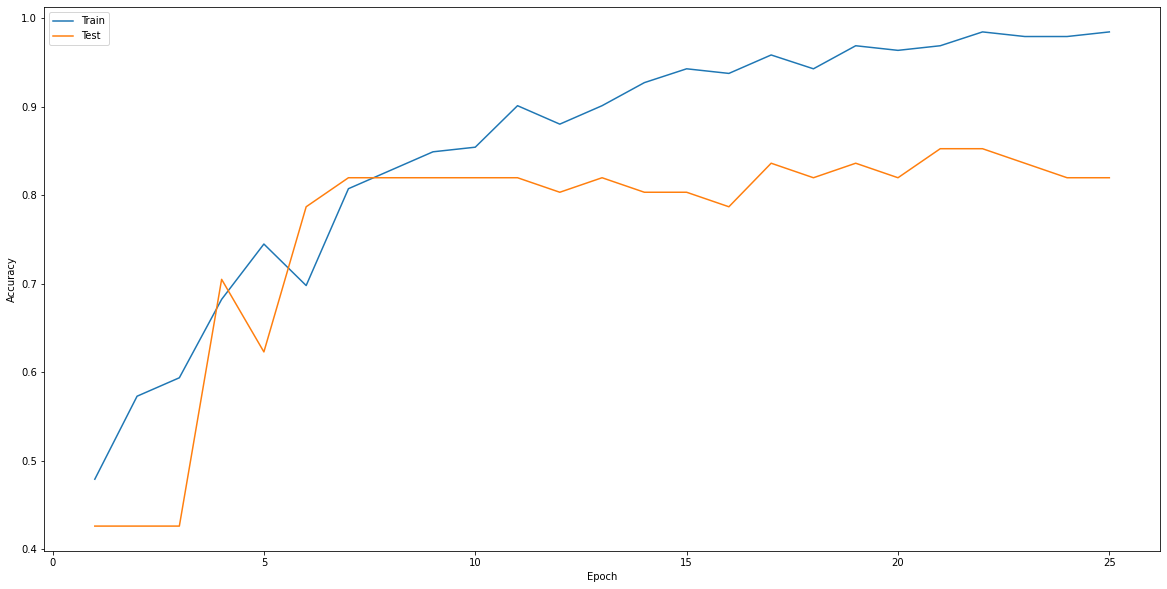

In [11]:
ax=Train.plot(x='Epoch',y='Accuracy',label='Train',figsize=(20,10))
Test.plot(x='Epoch',y='Accuracy',ax=ax,label='Test')
ax.set_ylabel('Accuracy')
a=1

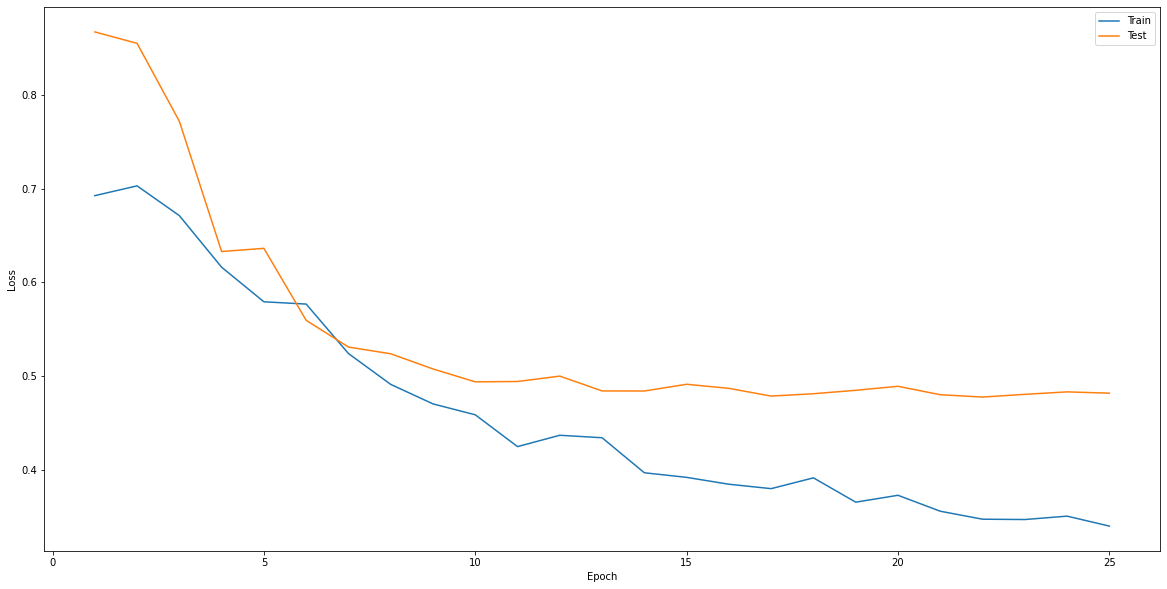

In [12]:
ax=Train.plot(x='Epoch',y='Loss',label='Train',figsize=(20,10))
Test.plot(x='Epoch',y='Loss',ax=ax,label='Test')
ax.set_ylabel('Loss')
a=1

In [15]:
Test

,Epoch,Accuracy,Loss
0,1.0,0.426229,0.866837
1,2.0,0.426229,0.854670
2,3.0,0.426229,0.771632
3,4.0,0.704918,0.632894
4,5.0,0.622951,0.636318
5,6.0,0.786885,0.559627
6,7.0,0.819672,0.531160
7,8.0,0.819672,0.523972
8,9.0,0.819672,0.507815
9,10.0,0.819672,0.494088


In [35]:
df=pd.read_csv('heart.csv')
X=df.drop(['output'],axis=1).to_numpy()
Y=df[['output']].to_numpy()

In [63]:
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import log_loss as Loss

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10, shuffle=True)
model=XGBR(n_estimators = 10,n_jobs=-1).fit(X_train,Y_train)

In [59]:
model=XGBR(n_estimators = 10,n_jobs=-1).fit(X_train,Y_train)

In [71]:
accuracy(model.predict(X_test)>0.5,Y_test.reshape(-1))

0.8360655737704918